# Ensemble Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import collections
import pickle
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, plot_precision_recall_curve, roc_curve, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.base import ClassifierMixin

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBClassifier

%matplotlib inline

In [28]:
sns.set_style('whitegrid')

In [29]:
data = {}
for dataset in os.listdir('../data/preprocessed'):
        with open(f'../data/preprocessed/{dataset}', 'rb') as fp:
            data[dataset[:-4]] = pickle.load(fp)
        
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [30]:
models = {}
for model in os.listdir('../models'):
    if model != 'softvote.pkl':
        with open(f'../models/{model}', 'rb') as fp:
            models[model[:-4]] = pickle.load(fp)

In [31]:
models

{'svcp': SVC(C=0.30000000000000004, coef0=0.7000000000000001, degree=2, kernel='poly',
     probability=True, random_state=42),
 'svcs': SVC(C=0.07, coef0=1.0, kernel='sigmoid', probability=True, random_state=42),
 'ab': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                    learning_rate=0.1, n_estimators=30, random_state=42),
 'lr': LogisticRegressionCV(random_state=42),
 'svcrbf': SVC(C=0.1, coef0=0.001, probability=True, random_state=42),
 'rf': RandomForestClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=40,
                        n_estimators=50, random_state=42),
 'knn': KNeighborsClassifier(n_neighbors=7, weights='distance'),
 'dt': DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=20,
                        random_state=42),
 'svcl': SVC(C=0.7000000000000001, kernel='linear', probability=True, random_state=42)}

In [32]:
for model in models:
    print(f'{model}:\t{recall_score(y_test, models[model].predict(X_test))}')

svcp:	0.8571428571428571
svcs:	0.8571428571428571
ab:	0.8571428571428571
lr:	0.8857142857142857
svcrbf:	0.8857142857142857
rf:	0.8571428571428571
knn:	0.8285714285714286
dt:	0.8571428571428571
svcl:	0.8857142857142857


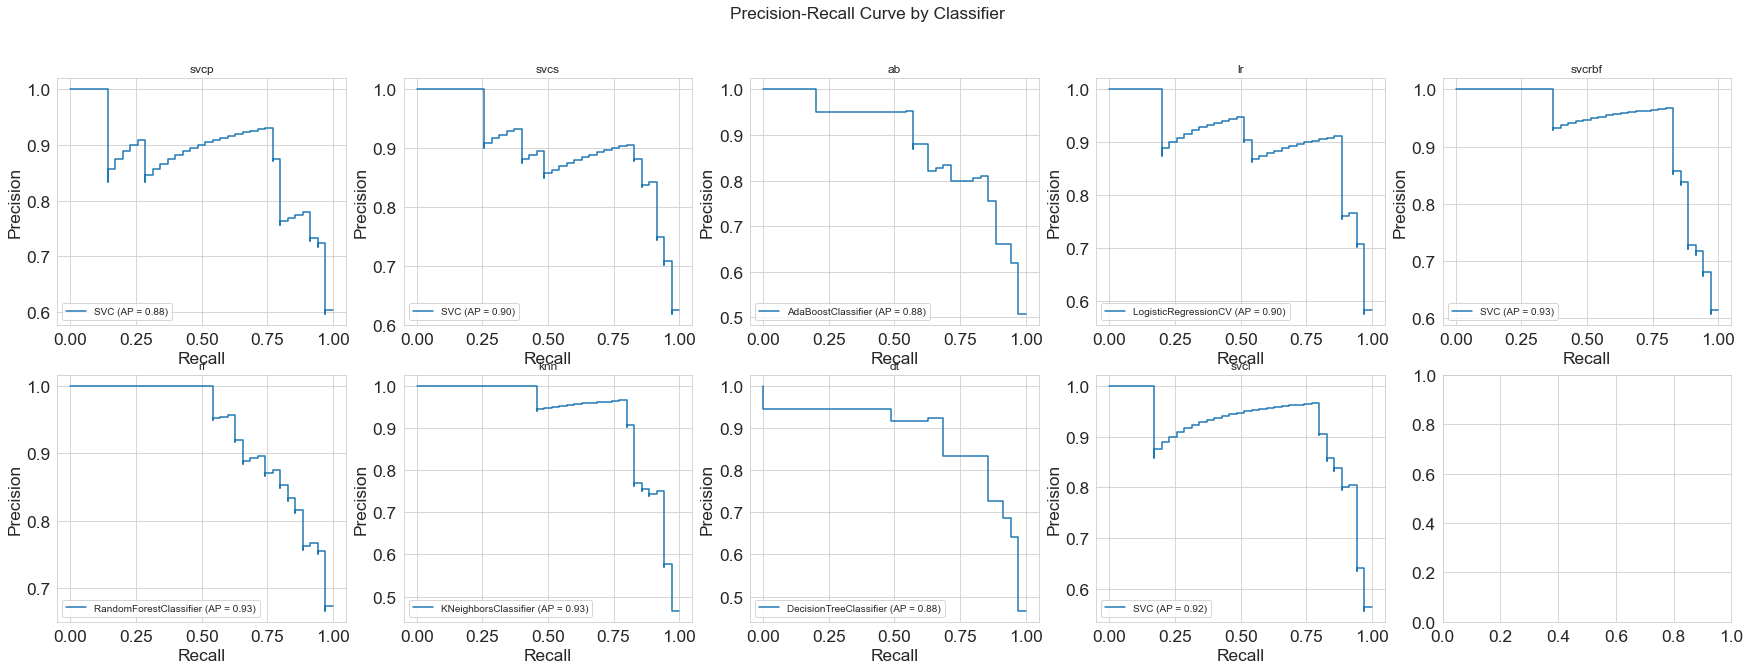

In [33]:
fig, axes = plt.subplots(2,5, figsize=(30,10))
fig.suptitle('Precision-Recall Curve by Classifier', fontsize='xx-large')
for i, model in enumerate(models):
    plot_precision_recall_curve(models[model], X_test, y_test, ax=axes[i//5][i%5])
    axes[i//5][i%5].set_title(model)
plt.savefig('../images/precision_recall_curves_all.png')

Here I selected the three top performing models: the sigmoid kernel from the SVCs, AdaBoost from the boosters, and the decision tree over the random forest, for a total of **3 individual models**. I combined them into a single voting classifier below.

In [34]:
clf_votehard = VotingClassifier(
    estimators=[(model, models[model]) for model in models],
    voting='hard')
clf_votehard.fit(X_train, y_train)
recall_score(y_test, clf_votehard.predict(X_test))

0.8571428571428571

In [35]:
confusion_matrix(y_test, clf_votehard.predict(X_test))

array([[33,  7],
       [ 5, 30]])

This ensemble method does as well as two of the individual models, the decision tree and AdaBoost, but not as well the sigmoid SVC. I tried the same model, but with a soft voting system, giving a little more weight to the sigmoid SVC as it performed best on its own. I also included the KNN model hoping the extra diversity in models might produce a more powerful ensemble.

In [36]:
weight_values = [1,2]
import itertools
weight_perms = list(itertools.product(weight_values, repeat=len(models)))

In [37]:
param_grid = {
#     'ab__base_estimator': [DecisionTreeClassifier(max_depth=1), LogisticRegression(solver='lbfgs', multi_class='auto')], 
#     'ab__n_estimators': [10, 30, 50, 1000], 
#     'ab__learning_rate': [.0001, .001, .01, .1],
#     'svcl__kernel': ['linear'], 
#     'svcl__C': np.linspace(.1, 1, 10), 
#     'svcl__gamma': ['scale', 'auto'],
#     'weights': weight_perms

}
gs_hard = GridSearchCV(clf_votehard, param_grid, scoring='recall', cv=5, verbose=0)
gs_hard.fit(X_train, y_train)

print(f'Train Recall: {gs_hard.best_score_}')
print(f'Test Recall: {recall_score(y_test, gs_hard.predict(X_test))}')
print(f'Train Accuracy: {accuracy_score(y_train, gs_hard.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, gs_hard.predict(X_test))}')
print(gs_hard.best_params_)

Train Recall: 0.7266666666666668
Test Recall: 0.8571428571428571
Train Accuracy: 0.8423423423423423
Test Accuracy: 0.84
{}


In [38]:
confusion_matrix(y_test, gs_hard.predict(X_test))

array([[33,  7],
       [ 5, 30]])

In [39]:
clf_votesoft = VotingClassifier(
    estimators=[('svcl', models['svcl']),
                ('lr', models['lr']), 
                ('ab', models['ab'])],
    voting='soft')
# clf_votesoft = VotingClassifier(
#     estimators=[(model, models[model]) for model in models],
#     voting='soft')
clf_votesoft.fit(X_train, y_train)
print(f'Train Recall: {recall_score(y_train, clf_votesoft.predict(X_train))}')
print(f'Test Recall: {recall_score(y_test, clf_votesoft.predict(X_test))}')

Train Recall: 0.7647058823529411
Test Recall: 0.8857142857142857


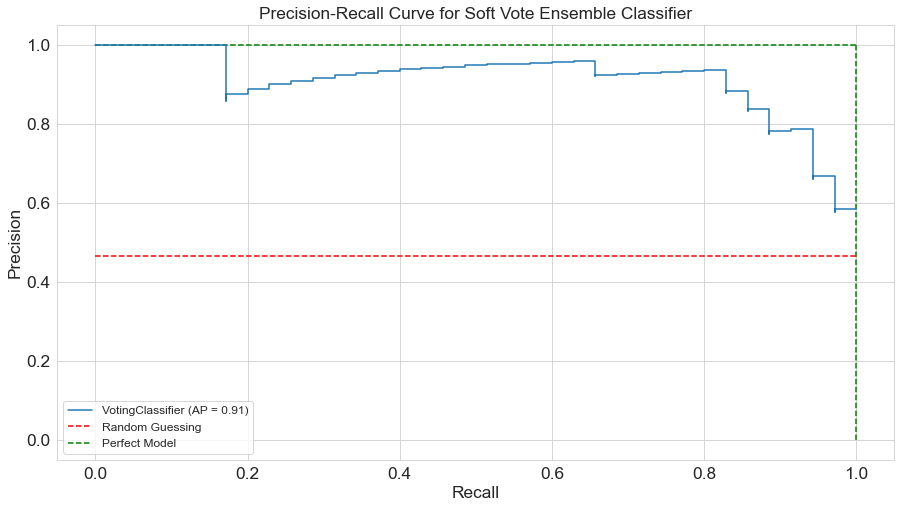

In [40]:
fig,ax = plt.subplots(1,1,figsize=(15,8))
plot_precision_recall_curve(clf_votesoft, X_test, y_test, ax=ax)
plt.rc('axes', labelsize='xx-large')
plt.rc('xtick', labelsize='xx-large')
plt.rc('ytick', labelsize='xx-large')
ax.set_title('Precision-Recall Curve for Soft Vote Ensemble Classifier', fontsize='xx-large')
neg_count, pos_count = y_test.value_counts()
plt.hlines(pos_count/(neg_count+pos_count), 0, 1, colors='red', linestyles='--', label='Random Guessing')
plt.hlines(1, 0, 1, colors='green', linestyle='--', label='Perfect Model')
plt.vlines(1, 0, 1, colors='green', linestyle='--')
plt.legend(fontsize='large')
plt.savefig('../images/precision_recall_curve_vote_soft.png')

This precision-recall curve looks a lot like the linear SVC model's, perhaps suggesting that the linear SVC is making most of the calls in the voting ensemble.

In [41]:
gs_soft = GridSearchCV(clf_votesoft, param_grid, scoring='recall', cv=5)
gs_soft.fit(X_train, y_train)

print(f'Train Recall: {gs_soft.best_score_}')
print(f'Test Recall: {recall_score(y_test, gs_soft.predict(X_test))}')
print(f'Train Accuracy: {accuracy_score(y_train, gs_soft.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, gs_soft.predict(X_test))}')
print(gs_soft.best_params_)

Train Recall: 0.7366666666666666
Test Recall: 0.8857142857142857
Train Accuracy: 0.8288288288288288
Test Accuracy: 0.8533333333333334
{}


In [42]:
with open('../models/softvote.pkl', 'wb') as fp:
    pickle.dump(gs_soft, fp)

In [43]:
confusion_matrix(y_test, gs_soft.predict(X_test))

array([[33,  7],
       [ 4, 31]])

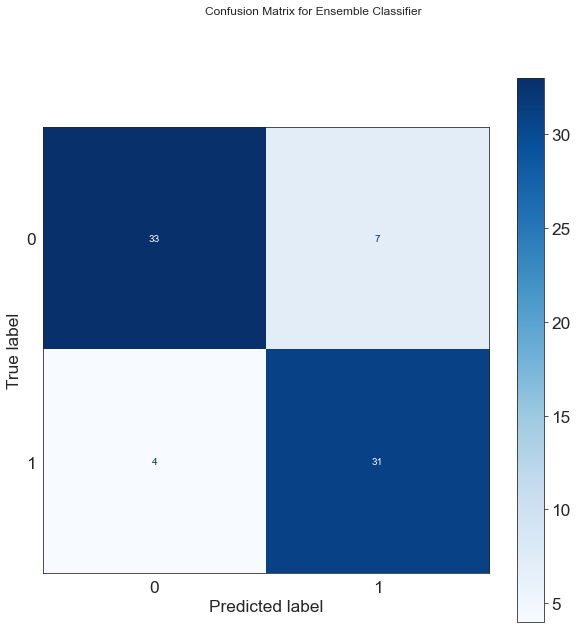

In [18]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(gs_soft, X_test, y_test, cmap='Blues', ax=ax)
plt.suptitle('Confusion Matrix for Ensemble Classifier')
plt.savefig('../images/conf_gs_soft.png')

In [19]:
thresholds = np.arange(0., 1., .05)
recalls = []
accuracies = []
for thr in thresholds:
    experimental_results = [1 if x > thr else 0 for x in gs_soft.predict_proba(X_test)[:,1]]
    recalls.append(recall_score(y_test, experimental_results))
    accuracies.append(accuracy_score(y_test, experimental_results))

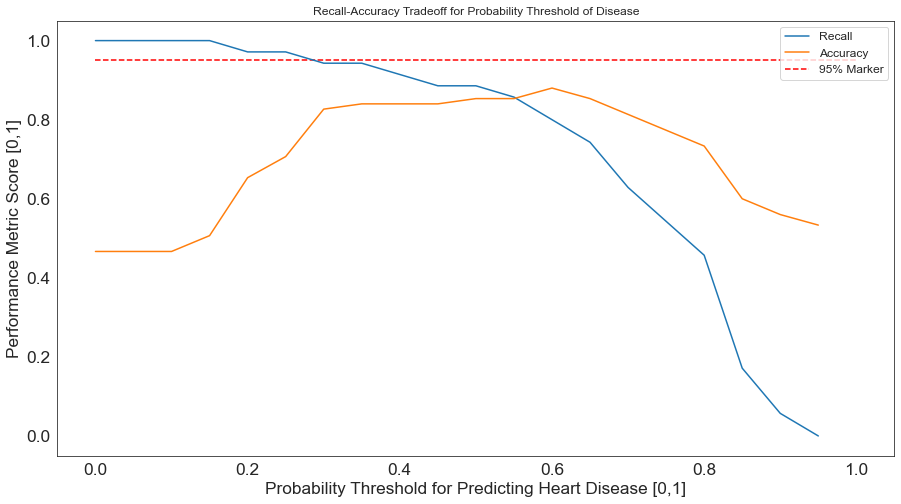

In [20]:
plt.figure(figsize=(15,8))
plt.plot(thresholds,recalls,label='Recall')
plt.plot(thresholds,accuracies,label='Accuracy')
plt.hlines(.95, 0, 1, colors='red', linestyle='--', label='95% Marker')
plt.legend()
plt.xlabel('Probability Threshold for Predicting Heart Disease [0,1]')
plt.ylabel('Performance Metric Score [0,1]', fontsize='xx-large')
plt.title('Recall-Accuracy Tradeoff for Probability Threshold of Disease')
plt.legend(fontsize='large')
plt.savefig('../images/recall_accuracy_curve_proba_thresholds.png')

In [21]:
threshold = 0.35
experimental_results = [1 if x > threshold else 0 for x in gs_soft.predict_proba(X_test)[:,1]]
print(f'Test Recall: {recall_score(y_test, experimental_results)}')
print(f'Test Accuracy: {accuracy_score(y_test, experimental_results)}')
confusion_matrix(y_test, experimental_results)

Test Recall: 0.9428571428571428
Test Accuracy: 0.84


array([[30, 10],
       [ 2, 33]])

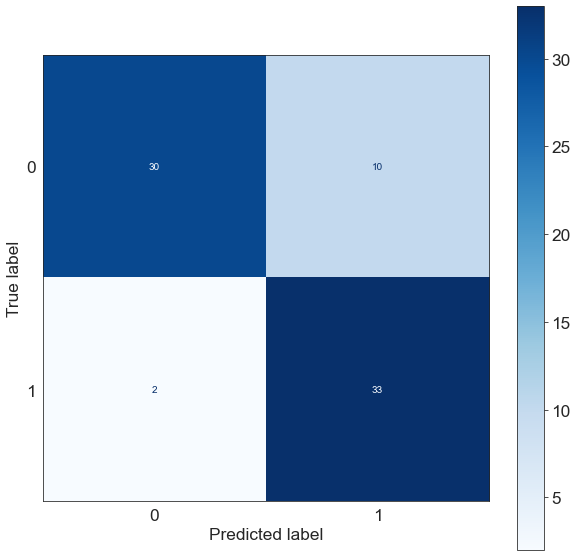

In [22]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(confusion_matrix(y_test, experimental_results)).plot(ax=ax, cmap='Blues')
plt.savefig('../images/conf_custom_soft.png')

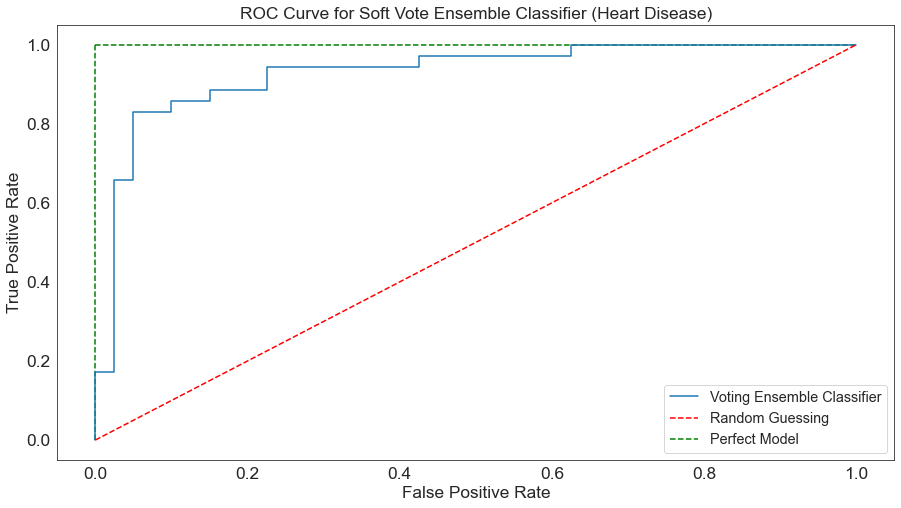

In [23]:
fpr, tpr, thres = roc_curve(y_test, [x[1] for x in gs_soft.predict_proba(X_test)])
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, label='Voting Ensemble Classifier')
plt.title('ROC Curve for Soft Vote Ensemble Classifier (Heart Disease)', fontsize='xx-large')
plt.hlines(1, 0, 1, color='green', linestyle='--', label='Perfect Model')
plt.vlines(0, 0, 1, color='green', linestyle='--')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize='x-large')
plt.savefig('../images/roc_softvote.png')